In [49]:
import os
import glob as gb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import rarfile
import keras.utils as image

In [50]:
DATASET_PATH = "V4.dataset-skin-deasease-capstone"

os.listdir(DATASET_PATH)

['1train',
 '2validation',
 '3test',
 'clean-dataset-train',
 'clean-dataset-validation',
 'dataset1',
 'dataset2']

In [51]:
TRAIN_DIR = os.path.join(DATASET_PATH, '1train')
VAL_DIR = os.path.join(DATASET_PATH, '2validation')
TEST_DIR = os.path.join(DATASET_PATH, '3test')

In [52]:
def img_count_in_folder(FOLDER_PATH):  
    print('-'*70)
    for folder in os.listdir(FOLDER_PATH):
        files=gb.glob(pathname=str(FOLDER_PATH + '/' + folder + '/*.jpg'))
        print(f'{len(files):4} gambar yang ditemukan di dalam folder {folder}')
    print('-'*70)

In [53]:
print("TRAIN DIR")
img_count_in_folder(TRAIN_DIR)
print("VAL_DIR")
img_count_in_folder(VAL_DIR)
print("TEST_DIR")
img_count_in_folder(TEST_DIR)

TRAIN DIR
----------------------------------------------------------------------
 332 gambar yang ditemukan di dalam folder Acne Vulgaris
 370 gambar yang ditemukan di dalam folder Actinic Keratosis
 551 gambar yang ditemukan di dalam folder Nail Fungus
 580 gambar yang ditemukan di dalam folder Psoriasis
 357 gambar yang ditemukan di dalam folder Seborrheic Keratoses
----------------------------------------------------------------------
VAL_DIR
----------------------------------------------------------------------
  90 gambar yang ditemukan di dalam folder Acne Vulgaris
  93 gambar yang ditemukan di dalam folder Actinic Keratosis
 138 gambar yang ditemukan di dalam folder Nail Fungus
 146 gambar yang ditemukan di dalam folder Psoriasis
  90 gambar yang ditemukan di dalam folder Seborrheic Keratoses
----------------------------------------------------------------------
TEST_DIR
----------------------------------------------------------------------
   0 gambar yang ditemukan di dalam fo

In [54]:
def show_images(img_files):
    plt.figure()
    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('xkcd:gray')
    
    for i in range(len(img_files)):
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        img=mpimg.imread(img_files[i])
        plt.imshow(img)
        plt.tight_layout()
        plt.axis('off')
        plt.title(img_files[i].split('\\')[2]) 
    
    plt.show()

In [55]:
def list_files(dir):
    arr=[]
    for root,dirs, files in os.walk(dir):
        for name in files:
            if name.endswith('.jpg'):
                arr.append(os.path.join(root, name))
                break
    return arr

<Figure size 640x480 with 0 Axes>

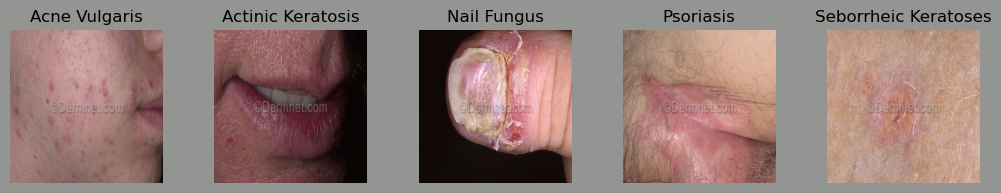

<Figure size 640x480 with 0 Axes>

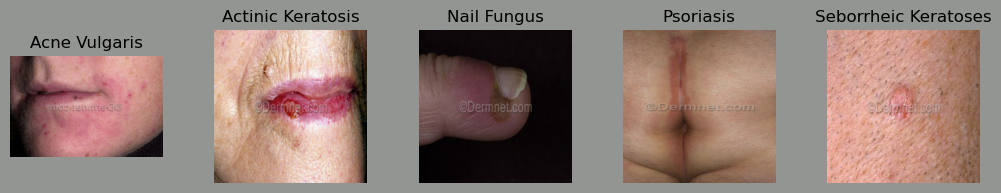

<Figure size 640x480 with 0 Axes>

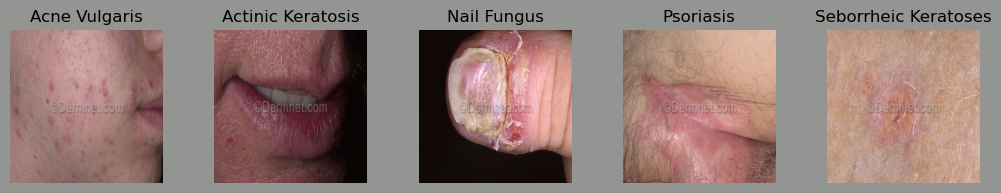

In [56]:
img_list1= list_files(TRAIN_DIR)
show_images(img_list1)

img_list2= list_files(VAL_DIR)
show_images(img_list2)

img_list3= list_files(TEST_DIR)
show_images(img_list1)

In [57]:
# Datagen for validation set dan training set
datagen = ImageDataGenerator(#preprocessing_function=img_segmentation,
                             rescale = 1./255,
                             rotation_range = 40,
                             zoom_range = 0.2,
                             width_shift_range=0.2, 
                             shear_range= 0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip= True,
                             fill_mode='nearest',
                             )

# ImageDataGenerator for test set
val_datagen = ImageDataGenerator(#preprocessing_function=img_segmentation,
                                 rescale=1./255,)
                                 #validation_split=0.1

test_datagen = ImageDataGenerator(rescale=1./255)

In [58]:
IMG_SIZE = (224, 224)

# Create train dataset
train_set = datagen.flow_from_directory(TRAIN_DIR, 
                                        batch_size= 64,
                                        target_size=IMG_SIZE)
                                        #class_mode='categorical'
                                        #seed=42

val_set = test_datagen.flow_from_directory(VAL_DIR, 
                                           #class_mode='categorical', 
                                           batch_size= 64,
                                           target_size=IMG_SIZE,)

test_set = test_datagen.flow_from_directory(TEST_DIR, 
                                           #class_mode='categorical', 
                                           batch_size= 64,
                                           target_size=IMG_SIZE,)

Found 2190 images belonging to 5 classes.
Found 557 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


In [59]:
Classifier_Model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE = (224, 224)

feature_extractor = hub.KerasLayer(Classifier_Model, input_shape=IMAGE_SIZE + (3,))

model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_set)

Epoch 1/100
35/35 [==============================] - 72s 2s/step - loss: 1.1090 - accuracy: 0.5731 - val_loss: 0.7201 - val_accuracy: 0.7433
Epoch 2/100
35/35 [==============================] - 72s 2s/step - loss: 0.6900 - accuracy: 0.7361 - val_loss: 0.6090 - val_accuracy: 0.7522
Epoch 3/100
35/35 [==============================] - 76s 2s/step - loss: 0.5945 - accuracy: 0.7808 - val_loss: 0.5282 - val_accuracy: 0.8043
Epoch 4/100
35/35 [==============================] - 77s 2s/step - loss: 0.5689 - accuracy: 0.7895 - val_loss: 0.5133 - val_accuracy: 0.8043
Epoch 5/100
35/35 [==============================] - 78s 2s/step - loss: 0.5215 - accuracy: 0.7977 - val_loss: 0.4890 - val_accuracy: 0.8187
Epoch 6/100
35/35 [==============================] - 93s 3s/step - loss: 0.5065 - accuracy: 0.8174 - val_loss: 0.4679 - val_accuracy: 0.8205
Epoch 7/100
35/35 [==============================] - 137s 4s/step - loss: 0.4720 - accuracy: 0.8242 - val_loss: 0.4551 - val_accuracy: 0.8330
Epoch 8/100


35/35 [==============================] - 78s 2s/step - loss: 0.2899 - accuracy: 0.8881 - val_loss: 0.3940 - val_accuracy: 0.8600
Epoch 59/100
35/35 [==============================] - 80s 2s/step - loss: 0.2756 - accuracy: 0.8982 - val_loss: 0.3926 - val_accuracy: 0.8546
Epoch 60/100
35/35 [==============================] - 78s 2s/step - loss: 0.2734 - accuracy: 0.8945 - val_loss: 0.4287 - val_accuracy: 0.8528
Epoch 61/100
35/35 [==============================] - 78s 2s/step - loss: 0.2888 - accuracy: 0.8918 - val_loss: 0.4129 - val_accuracy: 0.8438
Epoch 62/100
35/35 [==============================] - 79s 2s/step - loss: 0.2864 - accuracy: 0.8973 - val_loss: 0.3983 - val_accuracy: 0.8600
Epoch 63/100
35/35 [==============================] - 79s 2s/step - loss: 0.2725 - accuracy: 0.8968 - val_loss: 0.4054 - val_accuracy: 0.8510
Epoch 64/100
35/35 [==============================] - 78s 2s/step - loss: 0.2622 - accuracy: 0.9059 - val_loss: 0.3892 - val_accuracy: 0.8725
Epoch 65/100
35/35 

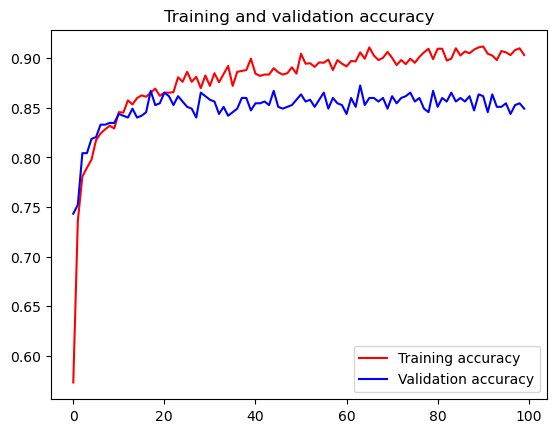

<Figure size 640x480 with 0 Axes>

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [62]:
loss, accuracy = model.evaluate(val_set, verbose=0)
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 0.39 and Accuracy is 84.92%


In [63]:
model_detection = 'ModelingV5.h5'

model.save(model_detection, save_format="h5")

In [96]:
my_model = tf.keras.models.load_model(
    ('ModelingV5.h5'), custom_objects={'KerasLayer':hub.KerasLayer}
)

In [97]:
loss, accuracy = my_model.evaluate(val_set, verbose=0)
print(f"Model Loss is {loss:.2f} and Accuracy is {100*np.round(accuracy, 4)}%")

Model Loss is 0.39 and Accuracy is 84.92%


In [95]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir("./tmp2/images")

print(images)

label = ['Acne Vulgaris', 'Actinic Keratosis', 'Nail Fungus', 'Psoriasis', 'Seborrheic Keratoses']

for i in images:
    print()
# predicting images
    path = './tmp2/images/' + i
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = my_model.predict(images, batch_size=10)
    print(path)
    
    predict = np.argmax(classes, axis=1)

    print(classes)
    data = {
        'Prediction' : label[predict[0]]}
    print(data)

['acne.jpg', 'acne2.jpg', 'acne3.jpg', 'actinic.jpg', 'nail.jpg', 'Psoriasis.jpg', 'Psoriasis1.jpg', 'seborrheic.jpg', 'seborrheic2.jpg']

1/1 [==============================] - 0s 446ms/step
./tmp2/images/acne.jpg
[[8.8349748e-01 2.4210509e-02 1.6792942e-04 8.6334139e-02 5.7900520e-03]]
{'Prediction': 'Acne Vulgaris'}

1/1 [==============================] - 0s 49ms/step
./tmp2/images/acne2.jpg
[[3.5928610e-01 1.3182762e-03 3.3774220e-05 6.3921177e-01 1.5009998e-04]]
{'Prediction': 'Psoriasis'}

1/1 [==============================] - 0s 48ms/step
./tmp2/images/acne3.jpg
[[9.9729782e-01 9.6634682e-04 1.0816514e-06 1.6706948e-03 6.4133841e-05]]
{'Prediction': 'Acne Vulgaris'}

1/1 [==============================] - 0s 47ms/step
./tmp2/images/actinic.jpg
[[0.00469533 0.01517205 0.00304871 0.9630907  0.0139932 ]]
{'Prediction': 'Psoriasis'}

1/1 [==============================] - 0s 47ms/step
./tmp2/images/nail.jpg
[[4.5588685e-08 3.2347730e-06 9.9951768e-01 4.4389250e-04 3.5151676e-05]]
{

In [92]:
# # CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

images = os.listdir("./tmp2/images")

print(images)

#label = ['Acne Vulgaris', 'Actinic Keratosis', 'Nail Fungus', 'Psoriasis', 'Seborrheic Keratoses']

for i in images:
    print()
# predicting images
    path = './tmp2/images/' + i
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = my_model.predict(images, batch_size=10)
    print(path)
    
    predict = np.argmax(classes, axis=1)

    print(classes[0])
    value = max(classes[0])
    print(value)
    index_value = np.argmax(classes[0])
    skin_value = ""
    
    if index_value == 0:
        skin_value = "Acne Vulgaris"
    elif index_value == 1:
        skin_value = "Actinic Keratosis"
    elif index_value == 2:
        skin_value = "Nail Fungus"
    elif index_value == 3:
        skin_value = "Psoriasis"
    elif index_value == 4:
        skin_value = "Seborrheic Keratoses"
    print(skin_value)

['acne.jpg', 'acne2.jpg', 'acne3.jpg', 'actinic.jpg', 'nail.jpg', 'Psoriasis.jpg', 'Psoriasis1.jpg', 'seborrheic.jpg', 'seborrheic2.jpg']

1/1 [==============================] - 0s 49ms/step
./tmp2/images/acne.jpg
[9.8500723e-01 9.2999660e-04 2.8918862e-07 1.1975018e-02 2.0875104e-03]
0.9850072
Acne Vulgaris

1/1 [==============================] - 0s 50ms/step
./tmp2/images/acne2.jpg
[2.9649115e-01 7.0462748e-04 1.5830736e-07 7.0279545e-01 8.6697646e-06]
0.70279545
Psoriasis

1/1 [==============================] - 0s 45ms/step
./tmp2/images/acne3.jpg
[9.9947625e-01 1.8931324e-04 3.3606911e-09 2.7434595e-04 6.0184935e-05]
0.99947625
Acne Vulgaris

1/1 [==============================] - 0s 46ms/step
./tmp2/images/actinic.jpg
[1.3994648e-04 6.7924351e-02 1.9571804e-04 9.2780113e-01 3.9389208e-03]
0.92780113
Psoriasis

1/1 [==============================] - 0s 45ms/step
./tmp2/images/nail.jpg
[9.9243324e-13 2.3618862e-08 9.9998093e-01 1.9093524e-05 2.4398312e-09]
0.9999809
Nail Fungus

1/1